# Model spectra and synthetic photometry

In this tutorial, we will have a look at some spectra of the DRIFT-PHOENIX atmospheric model. The spectra are first downloaded and added to the database. Then we will use the functionalities of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel) to extract a spectrum and calculate a photometric flux.

## Getting started

We start by importing the required Python modules.

In [1]:
from species import SpeciesInit
from species.data.database import Database
from species.read.read_model import ReadModel
from species.plot.plot_spectrum import plot_spectrum

Then we initialize [species](https://species.readthedocs.io/en/latest/species.html) with [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.species_init.SpeciesInit), which creates a default configuration file and the HDF5 database.

In [2]:
SpeciesInit()

species v0.8.3

Working folder: /Users/tomasstolker/applications/species/docs/tutorials

Creating species_config.ini... [DONE]
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]

Configuration settings:
   - Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
   - Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


## Adding model spectra to the database

To store the spectra, we first create an instance of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database).

In [3]:
database = Database()

Let's check which atmospheric models are available by running the [available_models](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.available_models) method of the [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) object.

In [4]:
_ = database.available_models()


-----------------------
Available model spectra
-----------------------

   - AMES-Cond:
      - Label = ames-cond
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [100, 6600]
      - Wavelength range (um): [0.5, 40]
      - Sampling (lambda/d_lambda): 4000
      - File size: 150 MB

   - AMES-Dusty:
      - Label = ames-dusty
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [500, 4000]
      - Wavelength range (um): [0.5, 40]
      - Sampling (lambda/d_lambda): 4000
      - File size: 58 MB

   - ATMO:
      - Label = atmo
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [200, 3000]
      - Wavelength range (um): [0.4, 6000]
      - Sampling (lambda/d_lambda): 1000
      - File size: 45 MB
      - Reference: Phillips et al. (2020)
      - URL: https://ui.adsabs.harvard.edu/abs/2020A%26A...637A..38P

   - ATMO CEQ:
      - Label = atmo-ceq
      - Model parameters: ['teff', 'logg']
      - Teff range (K): [200, 3000]
      - Wavele

Next, we will import the model spectra with the [add_model](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_model) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database). This step will automatically download the DRIFT-PHOENIX spectra (R = 2000) to the [data_folder](https://species.readthedocs.io/en/latest/configuration.html). The dowloaded data will then be unpacked and added to the database. We restrict the temperature range to 1300-1700 K, so not all spectra are added to the databse.

In [5]:
database.add_model(model='drift-phoenix', teff_range=(1300., 1700.))


-------------------------
Add grid of model spectra
-------------------------

Database tag: drift-phoenix
Model name: DRIFT-PHOENIX



100%|████████████████████████████████████████| 240M/240M [00:00<00:00, 193GB/s]
SHA256 hash of downloaded file: ba71a5e4d3d399a6f8ae249590c2e174e90ec2b55e712d350dad8ca1ae83a907
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.



Unpacking 118/496 model spectra from DRIFT-PHOENIX (229 MB)...data/drift-phoenix
data/drift-phoenix.tgz
 [DONE]

Please cite Helling et al. (2008) when using DRIFT-PHOENIX in a publication
Reference URL: https://ui.adsabs.harvard.edu/abs/2008ApJ...675L.105H

Wavelength range (um) = 0.1 - 50
Sampling (lambda/d_lambda) = 4000
Teff range (K) = 1300.0 - 1700.0

Adding DRIFT-PHOENIX model spectra... data/drift-phoenix/drift-phoenix_teff_1700_logg_5.5_feh_0.3_spec.dat 

Grid points stored in the database:
   - Teff = [1300. 1400. 1500. 1600. 1700.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]
   - [Fe/H] = [-0.6 -0.3 -0.   0.3]

Number of grid points per parameter:
   - teff: 5
   - logg: 6
   - feh: 4

Number of stored grid points: 120
Number of interpolated grid points: 0
Number of missing grid points: 0


Two of the grid points were missing in the original data and have been added with a linear, multidimensional interpolation.

## Interpolating the model grid

We will read the spectra from the database by creating an instance of [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel).

In [6]:
read_model = ReadModel(model='drift-phoenix', wavel_range=(0.5, 10.))

Let's see what the grid boundaries are from the spectra that are stored in the database.

In [7]:
read_model.get_bounds()

{'teff': (1300.0, 1700.0), 'logg': (3.0, 5.5), 'feh': (-0.6, 0.3)}

We will now interpolate the grid in the ($T_\mathrm{eff}$, $\log(g)$, $[\mathrm{Fe}/\mathrm{H}]$) space at some specific parameter values, which need to be provided in a dictionary. The radius and distance are optional, otherwise the emitted flux is given at the planet surface.

In [8]:
model_param = {'teff':1510., 'logg':4.1, 'feh':0.1, 'radius': 1., 'distance': 100.}

To interpolate a spectrum, we use the [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_model) method and provide the parameter dictionary, and also an optional spectral resolution. Together with `smooth=True`, the spectrum will be smoothed (but not resampeld) to the given spectral resolution.

In [9]:
model_box = read_model.get_model(model_param=model_param, spec_res=200.)

The data is stored in a [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox). Let's have a look at its content.

In [10]:
model_box.open_box()

Opening ModelBox...
model = drift-phoenix
type = None
wavelength = [ 0.49989727  0.50002105  0.50014486 ...  9.99710369  9.99957902
 10.00205496]
flux = [9.87533496e-20 9.80916961e-20 9.73738842e-20 ... 1.60596377e-18
 1.60964903e-18 1.61359501e-18]
parameters = {'teff': 1510.0, 'logg': 4.1, 'feh': 0.1, 'radius': 1.0, 'distance': 100.0, 'luminosity': 4.946207755957789e-05, 'mass': 5.079072973539381}
quantity = flux
contribution = None
bol_flux = None
spec_res = 200.0


We will now use the same atmospheric parameters but we will add some [ISM extinction](https://species.readthedocs.io/en/latest/species.util.html?#species.util.dust_util.ism_extinction) with the relation from [Cardelli et al. (1989)](https://ui.adsabs.harvard.edu/abs/1989ApJ...345..245C/abstract). Therefore, we add the V band extinction and reddening parameters to the dictionary.

In [11]:
model_param = {'teff':1510., 'logg':4.1, 'feh':0.1, 'radius': 1., 'distance': 100., 'ism_ext': 5., 'ism_red': 3.}

We use again the [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_model) method and store the result in a different [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox).

In [12]:
model_ext = read_model.get_model(model_param=model_param, spec_res=200.)

The two boxes with the model spectra are provided to the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum). We also include some filter profiles to indicate where the telluric windows are.

In [13]:
model_ext.open_box()

Opening ModelBox...
model = drift-phoenix
type = None
wavelength = [ 0.49989727  0.50002105  0.50014486 ...  9.99710369  9.99957902
 10.00205496]
flux = [5.55494996e-22 5.52221660e-22 5.48667641e-22 ... 1.53515310e-18
 1.53869176e-18 1.54247838e-18]
parameters = {'teff': 1510.0, 'logg': 4.1, 'feh': 0.1, 'radius': 1.0, 'distance': 100.0, 'ism_ext': 5.0, 'ism_red': 3.0, 'luminosity': 4.946207755957789e-05, 'mass': 5.079072973539381}
quantity = flux
contribution = None
bol_flux = None
spec_res = 200.0



-------------
Plot spectrum
-------------

Boxes:
   - ModelBox
   - ModelBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: ['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp']

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False


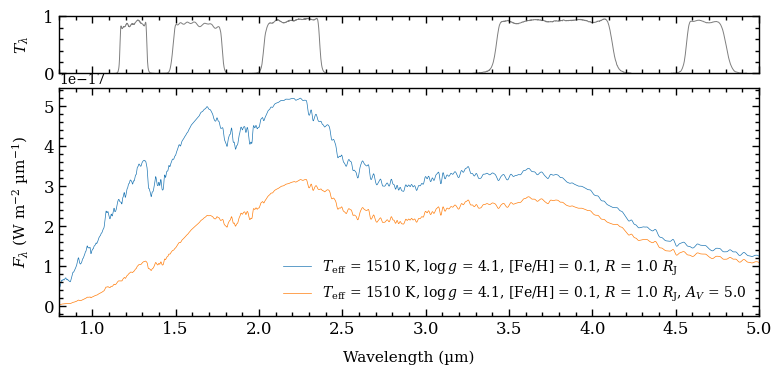

In [14]:
fig = plot_spectrum(boxes=[model_box, model_ext],
                    filters=['MKO/NSFCam.J', 'MKO/NSFCam.H', 'MKO/NSFCam.K', 'MKO/NSFCam.Lp', 'MKO/NSFCam.Mp'],
                    offset=(-0.15, -0.04),
                    xlim=(0.8, 5.),
                    # ylim=(0., 5.5e-17),
                    legend={'loc': 'lower right', 'frameon': False, 'fontsize': 10.},
                    figsize=(7., 3.),
                    output=None)

The [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The functionalities of [Matplotlib](https://matplotlib.org/stable/index.html) can be used for further customization of the plot. For example, the axes of the plot are stored at the `axes` attribute of `Figure`.

In [15]:
fig.axes

[<Axes: xlabel='Wavelength (µm)', ylabel='$F_\\lambda$ (W m$^{-2}$ µm$^{-1}$)'>,
 <Axes: ylabel='$T_\\lambda$'>]

## Extracting a spectrum at a grid point

It is also possible to extract a spectrum at one of the grid points, which doesn't require any interpolation. Let's check with the [get_points](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_points) method what parameter values are stored in the database.

In [16]:
read_model.get_points()

{'teff': array([1300., 1400., 1500., 1600., 1700.]),
 'logg': array([3. , 3.5, 4. , 4.5, 5. , 5.5]),
 'feh': array([-0.6, -0.3, -0. ,  0.3])}

We create a dictionary with values at one of the grid points.

In [17]:
model_param = {'teff':1500., 'logg':4., 'feh':0.}

And now use the [get_data](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_data) method to extract a spectrum.

In [18]:
model_full = read_model.get_data(model_param)

Let's make another plot with [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum). The spectrum is now shown at the spectral resolution as stored in the database ($R = 2000$).


-------------
Plot spectrum
-------------

Boxes:
   - ModelBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: None

Figure size: (7.0, 3.0)
Legend parameters: None
Include model name: False


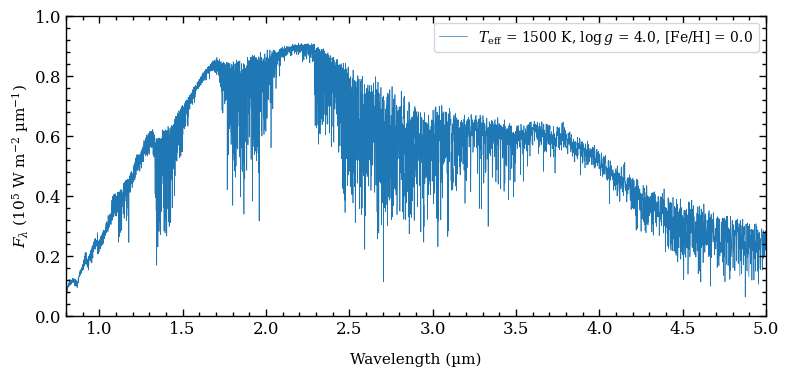

In [19]:
fig = plot_spectrum(boxes=[model_full],
                    filters=None,
                    offset=(-0.12, -0.05),
                    xlim=(0.8, 5.),
                    ylim=(0., 1e5),
                    legend={'loc': 'upper right', 'fontsize': 10.},
                    figsize=(7., 3.),
                    output=None)

## Calculating synthetic photometry

The [ReadModel](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel) class can also be used for calculating photometric fluxes and magnitudes. To do so, we create a new instance and set the `filter_name` argument to the [VLT/NACO M' filter](http://svo2.cab.inta-csic.es/svo/theory/fps/index.php?id=Paranal/NACO.Mp&&mode=browse&gname=Paranal&gname2=NACO#filter). This will automatically download and add the filter profile. 

In [20]:
read_model = ReadModel(model='drift-phoenix', filter_name='Paranal/NACO.Mp')

We create again a dictionary with the parameters but now run the [get_flux](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_flux) method, which returns the flux in W m-2 um-1.

In [21]:
model_param = {'teff':1510., 'logg':4.1, 'feh':0.1, 'radius': 1., 'distance': 100.}
flux = read_model.get_flux(model_param)
print(f'Flux (W m-2 um-1) = {flux[0]:.2e}')

100%|████████████████████████████████████████| 288k/288k [00:00<00:00, 141MB/s]



Adding spectrum: Vega
Reference: Bohlin et al. 2014, PASP, 126
URL: https://ui.adsabs.harvard.edu/abs/2014PASP..126..711B/abstract
Flux (W m-2 um-1) = 1.39e-17


Since we provided a radius and distance, the emitted flux at the planet surface has been scaled by $(\mathrm{radius}/\mathrm{distance})^2$.

Similarly, we can use the [get_magnitude](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_model.ReadModel.get_magnitude) method to calculate the magnitude for the NACO M' filter. Note that the returned absolute magnitude is set to `None` if the parameter dictionary does not contain a radius and distance.

In [22]:
app_mag, abs_mag = read_model.get_magnitude(model_param)
print(f'Apparent magnitude = {app_mag:.2f}')
print(f'Absolute magnitude = {abs_mag:.2f}')

Apparent magnitude = 15.46
Absolute magnitude = 10.46


As expected, at a distance of 100 pc, the difference between the apparent and absolute magnitude is 5.